<a href="https://colab.research.google.com/github/SerhiiAndreiko/HW_DATA_10/blob/main/HW_DATA_10_second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Частина 2**

​

В цій частині ми знову будемо працювати з датасетом fasion_mnist.



На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.



Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.



Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [18]:
img_width = 32
img_height = 32

In [19]:
# Завантаження даних
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [20]:
train_images.shape

(60000, 28, 28)

In [21]:

# Дублюємо канали, оскільки VGG16 очікує RGB
train_images = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images = np.repeat(test_images[..., np.newaxis], 3, axis=-1)

# Нормалізація пікселів
train_images = train_images / 255.0
test_images = test_images / 255.0

# Додавання паддингу
padding = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])
train_images_padded = tf.pad(train_images, padding, "CONSTANT")
test_images_padded = tf.pad(test_images, padding, "CONSTANT")

# Оголошення розміру вхідних даних
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# Конвертація міток в категоріальні дані
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [22]:
train_images_padded.shape

TensorShape([60000, 32, 32, 3])

In [23]:
# Завантаження VGG16 без верхніх Dense шарів та "заморожуємо" ваги
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

# Створення згорткової мережі з використанням VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

# Компіляція та навчання моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Epoch 1/10
188/188 [==============================] - 8s 38ms/step - loss: 0.7517 - accuracy: 0.7447 - val_loss: 0.5331 - val_accuracy: 0.8079
Epoch 2/10
188/188 [==============================] - 7s 35ms/step - loss: 0.4920 - accuracy: 0.8233 - val_loss: 0.4658 - val_accuracy: 0.8298
Epoch 3/10
188/188 [==============================] - 7s 36ms/step - loss: 0.4374 - accuracy: 0.8407 - val_loss: 0.4397 - val_accuracy: 0.8419
Epoch 4/10
188/188 [==============================] - 6s 34ms/step - loss: 0.4069 - accuracy: 0.8520 - val_loss: 0.4107 - val_accuracy: 0.8523
Epoch 5/10
188/188 [==============================] - 8s 43ms/step - loss: 0.3887 - accuracy: 0.8570 - val_loss: 0.3973 - val_accuracy: 0.8571
Epoch 6/10
188/188 [==============================] - 7s 38ms/step - loss: 0.3704 - accuracy: 0.8637 - val_loss: 0.3912 - val_accuracy: 0.8591
Epoch 7/10
188/188 [==============================] - 7s 35ms/step - loss: 0.3578 - accuracy: 0.8680 - val_loss: 0.3894 - val_accuracy: 0.8620

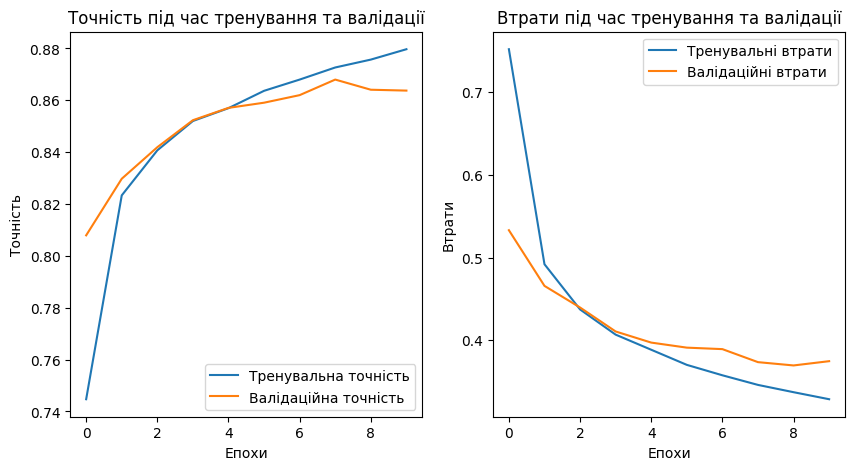

In [24]:
# Тренування моделі для train_images_padded
history_padding = model.fit(train_images_padded, train_labels, epochs=10, batch_size=256, validation_split=0.2)

# Виведення метрик точності та втрат для тренувального та тестового наборів даних
def print_metrics(name, loss, accuracy):
    print(f'{name} втрати: {loss:.4f}')
    print(f'{name} точність: {accuracy:.4f}')

# Оцінка моделі на тестових даних
test_loss, test_acc = model.evaluate(test_images_padded, test_labels)
print_metrics('Тест', test_loss, test_acc)

# Оцінка моделі на тренувальних даних
train_loss, train_acc = model.evaluate(train_images_padded, train_labels)
print_metrics('Тренувальні', train_loss, train_acc)

# Графіки для візуалізації тренувальних та валідаційних втрат та точності
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Тренувальна точність')
    plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
    plt.xlabel('Епохи')
    plt.ylabel('Точність')
    plt.title('Точність під час тренування та валідації')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Тренувальні втрати')
    plt.plot(history.history['val_loss'], label='Валідаційні втрати')
    plt.xlabel('Епохи')
    plt.ylabel('Втрати')
    plt.title('Втрати під час тренування та валідації')
    plt.legend()

    plt.show()

plot_history(history_padding)



In [25]:
model.save('model_1')

Epoch 1/50
750/750 [==============================] - 13s 16ms/step - loss: 0.6007 - accuracy: 0.7867 - val_loss: 0.4743 - val_accuracy: 0.8267
Epoch 2/50
750/750 [==============================] - 11s 14ms/step - loss: 0.4330 - accuracy: 0.8401 - val_loss: 0.4219 - val_accuracy: 0.8454
Epoch 3/50
750/750 [==============================] - 11s 15ms/step - loss: 0.3920 - accuracy: 0.8546 - val_loss: 0.4012 - val_accuracy: 0.8532
Epoch 4/50
750/750 [==============================] - 10s 13ms/step - loss: 0.3706 - accuracy: 0.8614 - val_loss: 0.3842 - val_accuracy: 0.8615
Epoch 5/50
750/750 [==============================] - 10s 13ms/step - loss: 0.3485 - accuracy: 0.8708 - val_loss: 0.3832 - val_accuracy: 0.8582
Epoch 6/50
750/750 [==============================] - 10s 14ms/step - loss: 0.3369 - accuracy: 0.8744 - val_loss: 0.3597 - val_accuracy: 0.8727
Epoch 7/50
750/750 [==============================] - 10s 14ms/step - loss: 0.3235 - accuracy: 0.8799 - val_loss: 0.3589 - val_accuracy:

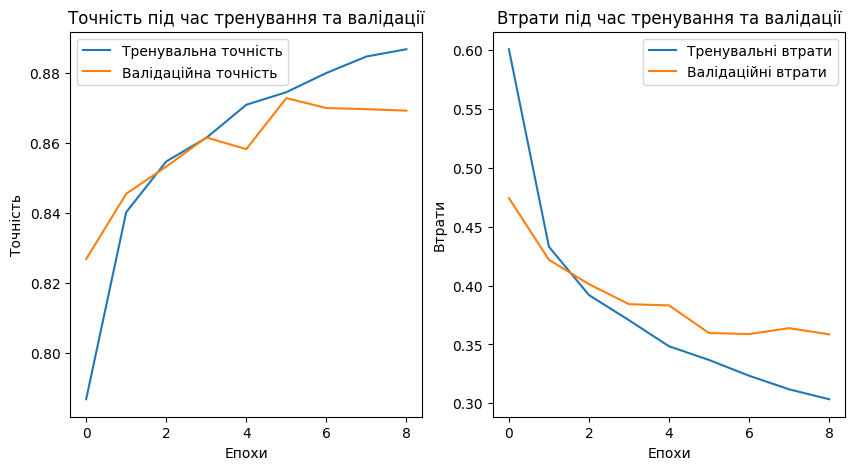

313/313 [==============================] - 4s 11ms/step - loss: 0.3635 - accuracy: 0.8686
Точність на тестових даних: 0.8686000108718872
1875/1875 [==============================] - 16s 8ms/step - loss: 0.3157 - accuracy: 0.8847
Точність на тренувальних даних: 0.8846666812896729


In [27]:
# Створення згорткової мережі з використанням VGG16
model_2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

# Компіляція та налаштування EarlyStopping
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Тренування моделі з використанням EarlyStopping
history_model_2 = model_2.fit(train_images_padded, train_labels, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Виведення історії точності та втрат на графіку
def plot_history_with_early_stopping(history):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Тренувальна точність')
    plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
    plt.xlabel('Епохи')
    plt.ylabel('Точність')
    plt.title('Точність під час тренування та валідації')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Тренувальні втрати')
    plt.plot(history.history['val_loss'], label='Валідаційні втрати')
    plt.xlabel('Епохи')
    plt.ylabel('Втрати')
    plt.title('Втрати під час тренування та валідації')
    plt.legend()

    plt.show()

plot_history_with_early_stopping(history_model_2)

# Оцінка точності на тестових даних
test_loss, test_acc = model_2.evaluate(test_images_padded, test_labels)
print(f'Точність на тестових даних: {test_acc}')

# Оцінка точності на тренувальних даних
train_loss, train_acc = model_2.evaluate(train_images_padded, train_labels)
print(f'Точність на тренувальних даних: {train_acc}')



In [28]:
model_2.save('model_2')

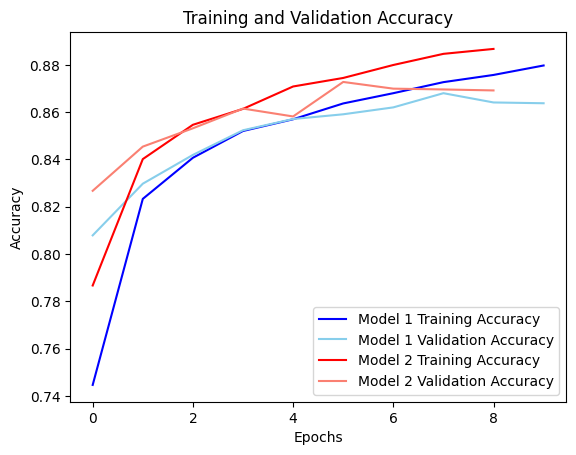

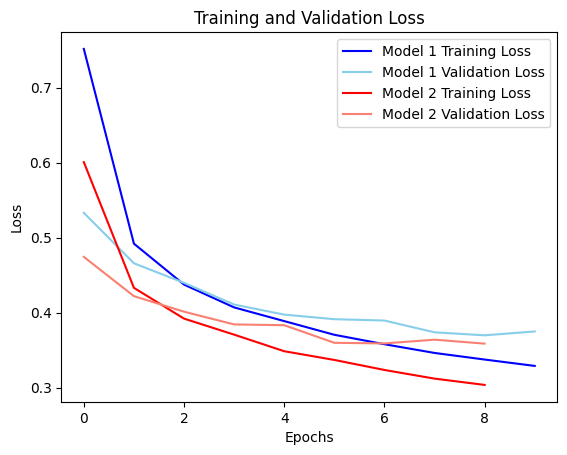

In [29]:
history_padding = history_padding.history
history_model_2 = history_model_2.history

# Побудувати графік точності
plt.plot(history_padding['accuracy'], label='Model 1 Training Accuracy', color='blue')
plt.plot(history_padding['val_accuracy'], label='Model 1 Validation Accuracy', color='skyblue')
plt.plot(history_model_2['accuracy'], label='Model 2 Training Accuracy', color='red')
plt.plot(history_model_2['val_accuracy'], label='Model 2 Validation Accuracy', color='salmon')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Побудувати графік втрат
plt.plot(history_padding['loss'], label='Model 1 Training Loss', color='blue')
plt.plot(history_padding['val_loss'], label='Model 1 Validation Loss', color='skyblue')
plt.plot(history_model_2['loss'], label='Model 2 Training Loss', color='red')
plt.plot(history_model_2['val_loss'], label='Model 2 Validation Loss', color='salmon')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Висновок**

Використання моделі VGG16 може бути вимогливим з точки зору обчислювальних ресурсів. Без використання T4 ця модель може бути недоступною. Хоча застосування різних методів для покращення результатів може призвести до невеликого підвищення точності на 1-2%, проте цей приріст не є значним. При виборі методів для розв'язання завдань завжди слід керуватися розумінням того, що якщо потрібна точність вже досягнута, необов'язково вибирати більш складні методи, які можуть вимагати значних обчислювальних та часових ресурсів, але не суттєво поліпшити результати.